In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
class NumericalSolver:
    calculate_a = lambda self, T: np.sqrt(self.gamma * self.R * T)
    calculate_mu = lambda self, T: self.mu0 * ((T/self.T0)**(3/2)) * (self.T0 + 110) / (T + 110)
    calculate_rho = lambda self, p, T: p / (self.R * T)
    calculate_Re_var = lambda self, rho, u, T, var: (rho * u * var) / self.calculate_mu(T)
    calculate_k = lambda self, T: self.calculate_mu(T) * self.cp / self.Pr
    calculate_lambda = lambda self, T: -2/3 * self.calculate_mu(T)
    
    def __init__(self, grid_sizes=(70, 70), M_inf=4, T_inf=288.16, p_inf=101325, cfl=0.6, n_iters=3000):
        self.x_grid_size, self.y_grid_size = grid_sizes
        self.nx, self.ny = self.x_grid_size + 1, self.y_grid_size + 1
        
        self.gamma = 1.4
        self.Pr = 0.71
        self.R = 287
        self.mu0 = 1.7894*1e-5
        self.T0 = 288.16
        self.cfl = cfl
        
        self.M_inf = M_inf
        self.T_inf = T_inf
        self.p_inf = p_inf
        self.a_inf = self.calculate_a(T_inf)
        self.u_inf = M_inf * self.a_inf
        self.v_inf = 0
        self.LHORI = 1e-5
        
        self.T_w = np.copy(T_inf)
        self.mu_inf = self.calculate_mu(T_inf)
        
        self.cv = self.R / (self.gamma-1)
        self.cp = self.gamma * self.cv
        self.rho_inf = self.calculate_rho(p_inf, T_inf)
        self.Re_l = self.calculate_Re_var(self.rho_inf, self.u_inf, T_inf, self.LHORI)
        self.e_inf = self.cv * T_inf
        self.k_inf = self.calculate_k(T_inf)
        
        self.delta = (5 * self.LHORI) / np.sqrt(self.Re_l)
        self.LVERT = 5 * self.delta
        self.dx = self.LHORI / self.x_grid_size
        self.dy = self.LVERT / self.y_grid_size
        self.x = np.arange(self.nx) * self.dx + 1e-10 # avoid zero division
        self.y = np.arange(self.ny) * self.dy 
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='ij')
        
        self.n_vars = 5
        self.n_eq = 4
        self.n_iters = n_iters
        self.tf = 0
        self.initial_data = np.array([
            self.rho_inf,
            self.u_inf,
            self.v_inf,
            p_inf,
            T_inf
        ])
        
    def get_xx(self):
        return self.xx
    
    def get_yy(self):
        return self.yy
        
    def initial_condition(self):
        V = np.zeros((self.n_vars, self.nx, self.ny))
        for i in range(self.n_vars):
            V[i] = self.initial_data[i]
        return V
    
    def boundary_condition(self, V):
        # inflow/upper boundary (case 2)
        # x = xa, ya <= y <= yb
        s = np.index_exp[0, :]
        for i in range(1, self.n_vars):
            V[i][s] = self.initial_data[i]
        V[0][s] = self.calculate_rho(V[3][s], V[4][s])
        # y = yb, xa <= x <= xb
        s = np.index_exp[:, -1]
        for i in range(1, self.n_vars):
            V[i][s] = self.initial_data[i]
        V[0][s] = self.calculate_rho(V[3][s], V[4][s])
        
        # surface (case 3)
        # y = ya, xa <= x <= xb
        s = np.index_exp[:, 0]
        V[1][s] = 0
        V[2][s] = 0
        V[3][s] = 2 * V[3][:, 1] - V[3][:, 2]
        V[4][s] = self.T_w
        V[0][s] = self.calculate_rho(V[3][s], V[4][s])
        
        # outflow (case 4)
        # x = xb, ya <= y <= yb
        s = np.index_exp[-1, :]
        for i in range(1, self.n_vars):
            # f(nx, j) = 2*f(nx-1, j) - f(nx-2, j)
            V[i][s] = 2 * V[i][-2, :] - V[i][-3, :]
        V[0][s] = self.calculate_rho(V[3][s], V[4][s])
        
        # leading edge (case 1)
        # x = xa, y = ya
        s = np.index_exp[0, 0]
        V[1][s] = 0
        V[2][s] = 0
        V[3][s] = self.p_inf
        V[4][s] = self.T_inf
        V[0][s] = self.calculate_rho(V[3][s], V[4][s])
        
        return V
    
    def transform_V_to_U(self, V):
        U = np.zeros((self.n_eq, self.nx, self.ny))
        U[0] = V[0]
        U[1] = V[0] * V[1]
        U[2] = V[0] * V[2]
        velocity2 = np.square(V[1]) + np.square(V[2])
        U[3] = V[0] * (self.cv * V[4] + velocity2 / 2)
        return U
    
    def transform_U_to_V(self, U):
        V = np.zeros((self.n_vars, self.nx, self.ny))
        V[0] = U[0]
        V[1] = U[1] / U[0]
        V[2] = U[2] / U[0]
        velocity2 = np.square(V[1]) + np.square(V[2])
        V[4] = 1/self.cv * (U[3] / U[0] - velocity2 / 2)
        V[3] = V[0] * self.R * V[4]
        return V
    
    def timestep(self, V):
        rho, u, v, T = V[0], V[1], V[2], V[4]
        a = self.calculate_a(T)
        mu = self.calculate_mu(T)
        k1 = (1/np.square(self.dx) + 1/np.square(self.dy))
        k2 = np.sqrt(k1)
        v_pr = np.max(4/3*mu * (self.gamma*mu/self.Pr) / rho)
        
        dt_cfl = 1 / (np.abs(u)/self.dx + np.abs(v)/self.dy +a*k2 + 2*v_pr*k1)
        dt = np.min(self.cfl * dt_cfl)
        return dt
    
    def calculate_Dx(self, u):
        Dx = np.zeros((self.nx, self.ny))
        
        # i = 0
        # du/dx(0, j) = (u(1, j) - u(0, j)) / dx
        Dx[0, :] = (u[1, :] - u[0, :]) / self.dx
        # i = 1,nx-1
        # du/dx(i, j) = (u(i+1, j) - u(i-1, j)) / (2*dx)
        Dx[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2*self.dx)
        # i = nx
        # du/dx(nx, j) = (u(nx, j) - u(nx-1, j)) / dx
        Dx[-1, :] = (u[-1, :] - u[-2, :]) / self.dx
        
        return Dx
    
    def calculate_Dy(self, u):
        Dy = np.zeros((self.nx, self.ny))
        
        # j = 0
        # du/dy(i, 0) = (u(i, 1) - u(i, 0)) / dy
        Dy[:, 0] = (u[:, 1] - u[:, 0]) / self.dy
        # j = 1,ny-1
        # du/dy(i, j) = (u(i, j+1) - u(i, j-1)) / (2*dy)
        Dy[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2*self.dy)
        # j = ny
        # du/dy(i, ny) = (u(i, ny) - u(i, ny-1)) / dy
        Dy[:, -1] = (u[:, -1] - u[:, -2]) / self.dy
        
        return Dy
    
    def calculate_tau_xy(self, u, v, T):
        # tau_xy = mu * (du/dy + dv/dx)
        
        mu = self.calculate_mu(T)
        Dy_u = self.calculate_Dy(u)
        Dx_v = self.calculate_Dx(v)
        tau_xy = mu * (Dy_u + Dx_v)
        
        return tau_xy
    
    def calculate_tau_xx(self, u, v, T):
        # tau_xx = lambda * (du/dx + dv/dy) + 2*mu * du/dx
        # lambda = -2/3 * mu
        
        mu = self.calculate_mu(T)
        _lambda = self.calculate_lambda(T)
        Dx_u = self.calculate_Dx(u)
        Dy_v = self.calculate_Dy(v)
        tau_xx = _lambda * (Dx_u + Dy_v) + 2*mu * Dx_u
        
        return tau_xx
    
    def calculate_tau_yy(self, u, v, T):
        # tau_yy = lambda * (du/dx + dv/dy) + 2*mu * dv/dy
        # lambda = -2/3 * mu
        
        mu = self.calculate_mu(T)
        _lambda = self.calculate_lambda(T)
        Dx_u = self.calculate_Dx(u)
        Dy_v = self.calculate_Dy(v)
        tau_yy = _lambda * (Dx_u + Dy_v) + 2*mu * Dy_v
        
        return tau_yy
    
    def calculate_qx(self, T):
        # qx = -k * dT/dx
        
        k = self.calculate_k(T)
        Dx_T = self.calculate_Dx(T)
        qx = -k * Dx_T
        
        return qx
    
    def calculate_qy(self, T):
        # qy = -k * dT/dy
        
        k = self.calculate_k(T)
        Dy_T = self.calculate_Dy(T)
        qy = -k * Dy_T
        
        return qy
        
    def calculate_flow_Dx(self, xi, u):
        # i = 1,nx-1, j = 0,ny
        Dx_xi_u = np.zeros((self.nx, self.ny))
        
        ur = 0.5*(u[2:, :] + u[1:-1, :])
        ul = 0.5*(u[1:-1, :] + u[:-2, :])
        
        xi_r_ur = 0.5*xi[1:-1, :]*(ur + np.abs(ur)) + 0.5*xi[2:, :]*(ur - np.abs(ur))
        xi_l_ul = 0.5*xi[:-2, :]*(ul + np.abs(ul)) + 0.5*xi[1:-1, :]*(ul - np.abs(ul))
        
        Dx_xi_u[1:-1, :] = (xi_r_ur - xi_l_ul) / self.dx
          
        return Dx_xi_u
    
    def calculate_flow_Dy(self, xi, v):
        # i = 0,nx, j = 1,ny-1
        Dy_xi_v = np.zeros((self.nx, self.ny))
        
        vr = 0.5*(v[:, 2:] + v[:, 1:-1])
        vl = 0.5*(v[:, 1:-1] + v[:, :-2])
        
        xi_r_vr = 0.5*xi[:, 1:-1]*(vr + np.abs(vr)) + 0.5*xi[:, 2:]*(vr - np.abs(vr))
        xi_l_vl = 0.5*xi[:, :-2]*(vl + np.abs(vl)) + 0.5*xi[:, 1:-1]*(vl - np.abs(vl))
        
        Dy_xi_v[:, 1:-1] = (xi_r_vr - xi_l_vl) / self.dy
        
        return Dy_xi_v
    
    def calculate_R(self, U, V):
        U1, U2, U3, U5 = U
        u, v, p, T = V[1:]
        
        Dx_p = self.calculate_Dx(p)
        Dy_p = self.calculate_Dy(p)
        tau_xy = self.calculate_tau_xy(u, v, T)
        tau_xx = self.calculate_tau_xx(u, v, T)
        tau_yy = self.calculate_tau_yy(u, v, T)
        qx = self.calculate_qx(T)
        qy = self.calculate_qy(T)
        
        # Continuity:
        Dx_rho_u = self.calculate_flow_Dx(U1, u)
        Dy_rho_v = self.calculate_flow_Dy(U1, v)
        Dt_rho = -(Dx_rho_u + Dy_rho_v)
        
        # x Momentum:
        Dx_rho_uu = self.calculate_flow_Dx(U2, u)
        Dx_tau_xx = self.calculate_Dx(tau_xx)
        
        Dy_rho_uv = self.calculate_flow_Dy(U2, v)
        Dy_tau_yx = self.calculate_Dy(tau_xy)
        
        Dt_rho_u = -(Dx_rho_uu + Dx_p - Dx_tau_xx) - (Dy_rho_uv - Dy_tau_yx)
        
        # y Momentum:
        Dx_rho_uv = self.calculate_flow_Dx(U3, u)
        Dx_tau_xy = self.calculate_Dx(tau_xy)
        
        Dy_rho_vv = self.calculate_flow_Dy(U3, v)
        Dy_tau_yy = self.calculate_Dy(tau_yy)
        
        Dt_rho_v = -(Dx_rho_uv - Dx_tau_xy) - (Dy_rho_vv + Dy_p - Dy_tau_yy)
        
        # Energy:
        Dx_Et_u = self.calculate_flow_Dx(U5, u)
        Dx_pu = self.calculate_flow_Dx(p, u)
        Dx_qx = self.calculate_Dx(qx)
        Dx_u_tau_xx = self.calculate_Dx(u * tau_xx)
        Dx_v_tau_xy = self.calculate_Dx(v * tau_xy)
        
        Dy_Et_v = self.calculate_flow_Dy(U5, v)
        Dy_pv = self.calculate_flow_Dy(p, v)
        Dy_qy = self.calculate_Dy(qy)
        Dy_u_tau_yx = self.calculate_Dy(u * tau_xy)
        Dy_v_tau_yy = self.calculate_Dy(v * tau_yy)
        
        Dt_Et = -(Dx_Et_u + Dx_pu + Dx_qx - Dx_u_tau_xx - Dx_v_tau_xy) \
            - (Dy_Et_v + Dy_pv + Dy_qy - Dy_u_tau_yx - Dy_v_tau_yy)
        
        R = np.array([
            Dt_rho,
            Dt_rho_u,
            Dt_rho_v,
            Dt_Et
        ])
        return R

    def rk4_method(self, U, V, dt):
        Rn = self.calculate_R(U, V)
        # step 1
        U1 = U + 0.5*dt*Rn
        R1 = self.calculate_R(U1, V)
        # step 2
        U2 = U + 0.5*dt*R1
        R2 = self.calculate_R(U2, V)
        # step 3
        U3 = U + dt*R2
        R3 = self.calculate_R(U3, V)
        # step 4
        U_new = U + (Rn + 2.0*R1 + 2.0*R2 + R3)*dt/6
        return U_new
    
    def solve(self):
        V_old = self.initial_condition()
        for _ in range(self.n_iters):
            dt = self.timestep(V_old)
            self.tf += dt
            
            U_old = self.transform_V_to_U(V_old)
            U_new = self.rk4_method(U_old, V_old, dt)
            V_new = self.transform_U_to_V(U_new)
            V_new = self.boundary_condition(V_new)

            V_old = np.copy(V_new)
        return V_new
    
    def plot_and_save(self, u, variable, file_name):
        plt.contourf(self.xx, self.yy, u, cmap='rainbow')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'{variable} contours')
        plt.colorbar()
        np.save(file_name, u)
        plt.savefig(variable)

In [4]:
solver = NumericalSolver()

In [5]:
rho, u, v, p, T = solver.solve()

In [6]:
xx, yy = solver.get_xx(), solver.get_yy()
np.savez('arrays', xx=xx, yy=yy)

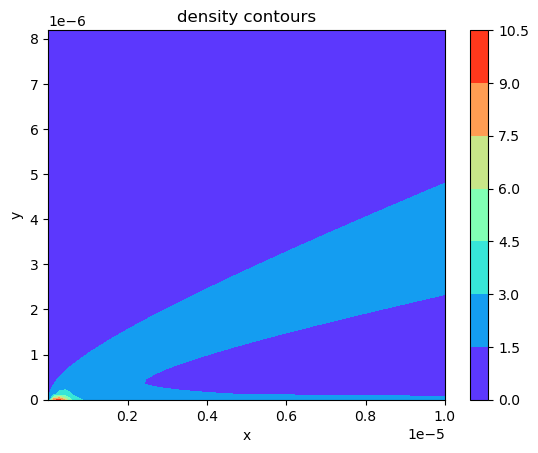

In [7]:
solver.plot_and_save(rho, 'density', 'rho')

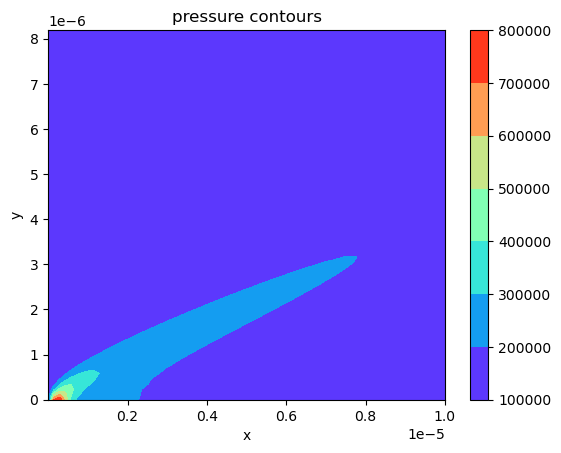

In [8]:
solver.plot_and_save(p, 'pressure', 'p')

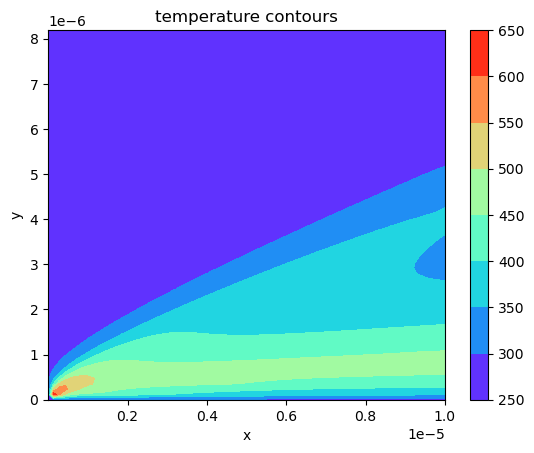

In [9]:
solver.plot_and_save(T, 'temperature', 'T')

In [10]:
np.savez('velocity_field', u=u, v=v)